In [2]:
from __future__ import annotations
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from collections import defaultdict

from util_funcs import calculate_prevalence
from util_funcs import calculate_ci
from util_funcs import calculate_relrisk
from util_funcs import select_valid

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [3]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')
master.head()

,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,other_met,distant_ln
0,108,NaN,2015,2020,75-79 years,Vulva,Vulva,Vulva,Vulva,Tis,N0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,BENIGN,2,0,NaN,NaN,8542,8500-8549: ductal and lobular neoplasms,False,False,False,False,NaN,NaN
1,137,"2,017.000",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,9730-9739: plasma cell tumors,NaN,NaN,NaN,NaN,NaN,NaN
2,139,"2,011.000",2003,2011,60-64 years,NHL - Extranodal,Non-Hodgkin Lymphoma,Lung and Bronchus,Lung and Bronchus,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,NaN,NaN,MALIGNANT,3,0,NaN,NaN,9699,9670-9699: nhl - mature b-cell lymphomas,NaN,NaN,NaN,NaN,NaN,NaN
3,139,"2,011.000",2007,2011,65-69 years,Breast,Breast,Breast,Breast,Tis,N0,0,NaN,NaN,NaN,G3,NaN,NaN,0.000,NaN,BENIGN,3,0,NaN,NaN,8010,"8010-8049: epithelial neoplasms, NOS",NaN,NaN,NaN,NaN,NaN,NaN
4,139,"2,011.000",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.000,0.000,MALIGNANT,3,0,NaN,HR-/HER2-,8500,8500-8549: ductal and lobular neoplasms,False,False,False,False,NaN,NaN


In [4]:

from util_funcs import do_basic_filtering
from util_funcs import do_basic_formatting
from util_funcs import remove_identical_primary_secondary_cases

print('\nFiltering')
maintable = do_basic_filtering(master.copy())
maintable = remove_identical_primary_secondary_cases(maintable)

print('\nFormatting')
maintable = do_basic_formatting(maintable)

maintable.head()


Filtering
Reginning records: 5604583
Removing records not in range (2010, 2020)... removed 371509 records
Removing records with non 'MALIGNANT' behavior... removed 632160 records
Handling patients with multiple records of same cancer_type... removed 82397 records

Final records: 4518517, patients: 4238366
Removing MET records where primary tissue is identical to secondary tissue
- removed 69806 records

Formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,other_met,distant_ln,any_met,hist_group,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD
4,139,"2,011.000",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.000,0.000,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NaN,NO,ductal and lobular neoplasms,Infiltrating duct carcinoma [+ others],T3,N0,II,G3
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.000,0.000,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,False,NO,ductal and lobular neoplasms,Infiltrating duct carcinoma [+ others],T2,N0,II,G3
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.000,0.000,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,False,NO,"cystic, mucinous and serous neoplasms",Serous carcinoma [+ others],T1,N0,I,G2
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.000,NaN,MALIGNANT,2,0,6.600,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,adenomas and adenocarcinomas,Adenoma [+ others],T1,N0,II,G2
8,265,"2,016.000",2011,2016,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,0.000,NaN,MALIGNANT,2,0,7.700,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,adenomas and adenocarcinomas,Adenoma [+ others],T2,N0,II,G3


In [39]:
### CONSTS & SELECTING FEATURES ###
FEATURE = 'cancer_group'
RESPONSES = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'other_met']
MIN_RECORDS = 2000
if FEATURE == 'cancer_group:hist_group':
    maintable[FEATURE] = maintable['cancer_group'] + ' (' + maintable['hist_group'] + ')'

if 'cancer_group' in FEATURE:
    maintable = maintable[maintable['cancer_group']!='Miscellaneous']
if 'hist_group' in FEATURE:
    maintable = maintable[maintable['hist_group']!='unspecified neoplasms']

if FEATURE == 'cancer_group':
    VALID_FEATURES = sorted([
        'Lung and Bronchus',
        'Stomach',
        'Colorectal',
        'Pancreas',
        'Prostate',
        'Breast',
        'Kidney and Renal Pelvis',
        'Skin',
        'Liver',
        'Thyroid',
        'Ovary',
    ])

else:
    table = maintable[maintable['any_met']=='YES']
    ctable = pd.DataFrame(index=sorted(list(table[FEATURE].unique())))
    ctable['records'] = table[FEATURE].value_counts()
    ctable['valid'] = ctable['records'] >= MIN_RECORDS
    ctable = ctable.sort_values('records', ascending=False)
    VALID_FEATURES = sorted(ctable[ctable['valid']==True].index)

    ### this code is if ensuring all metastatic sites reach a certain count. only partially formed. 
    # pframe = pd.DataFrame(index=sorted(list(table[FEATURE].unique())), columns=RESPONSES, dtype=float)
    # pframe.index.name = FEATURE 

    # for res in pframe.columns.to_list():
    #     rcounts = table.groupby(FEATURE)[res].value_counts().unstack().fillna(0).astype(int)
    #     rcounts['total'] = rcounts.sum(axis=1)
    #     rcounts['prop'] = rcounts['YES'] / rcounts['total']
    #     assert rcounts['prop'].max() <= 1
    #     pframe[res] = rcounts['YES']

    # pframe = pframe.fillna(0)
    # pframe = pframe.astype(int)
    # pframe['sum']

for feat in VALID_FEATURES:
    print(feat)
    

Breast
Colorectal
Kidney and Renal Pelvis
Liver
Lung and Bronchus
Ovary
Pancreas
Prostate
Skin
Stomach
Thyroid


In [40]:
### GENERERATE PROPORTIONS ###
table = maintable[(maintable['any_met']=='YES') & (maintable[FEATURE].isin(set(VALID_FEATURES)))]
VALID_FEATURES = sorted(list(table[FEATURE].unique()))
pframe = pd.DataFrame(index=VALID_FEATURES, columns=RESPONSES, dtype=float)
pframe.index.name = FEATURE

for res in pframe.columns.to_list():
    rcounts = table.groupby(FEATURE)[res].value_counts().unstack().fillna(0).astype(int)
    rcounts['total'] = rcounts.sum(axis=1)
    rcounts['prop'] = rcounts['YES'] / rcounts['total']
    assert rcounts['prop'].max() <= 1
    pframe[res] = rcounts['prop']

pframe = pframe.fillna(0.0)
pframe = pframe.astype(float)
pframe


,brain_met,bone_met,lung_met,liver_met,other_met
cancer_group,,,,,
Breast,0.084,0.736,0.349,0.282,0.201
Colorectal,0.016,0.074,0.295,0.831,0.283
Kidney and Renal Pelvis,0.114,0.428,0.656,0.240,0.297
Liver,0.031,0.414,0.561,0.000,0.346
Lung and Bronchus,0.352,0.508,0.000,0.312,0.469
Ovary,0.014,0.063,0.325,0.393,0.781
Pancreas,0.009,0.086,0.235,0.844,0.278
Prostate,0.013,0.962,0.100,0.050,0.068
Skin,0.403,0.285,0.571,0.313,0.440


In [41]:
### NORMALISE PROPORTIONS ###
rowsums = pframe.sum(axis=1)
nframe = pd.DataFrame(index=pframe.index, columns=pframe.columns, dtype=float)
for feat in nframe.index:
    for res in nframe.columns:
        nframe.loc[feat, res] = pframe.loc[feat, res] / rowsums.loc[feat]

# sns.clustermap(data=nframe, cmap='OrRd', square=True, row_cluster=True)
nframe 

,brain_met,bone_met,lung_met,liver_met,other_met
cancer_group,,,,,
Breast,0.051,0.446,0.211,0.170,0.122
Colorectal,0.011,0.049,0.197,0.554,0.189
Kidney and Renal Pelvis,0.066,0.247,0.378,0.138,0.171
Liver,0.023,0.306,0.415,0.000,0.256
Lung and Bronchus,0.214,0.310,0.000,0.190,0.286
Ovary,0.009,0.040,0.206,0.249,0.495
Pancreas,0.006,0.059,0.161,0.581,0.192
Prostate,0.011,0.807,0.083,0.042,0.057
Skin,0.200,0.142,0.284,0.156,0.219


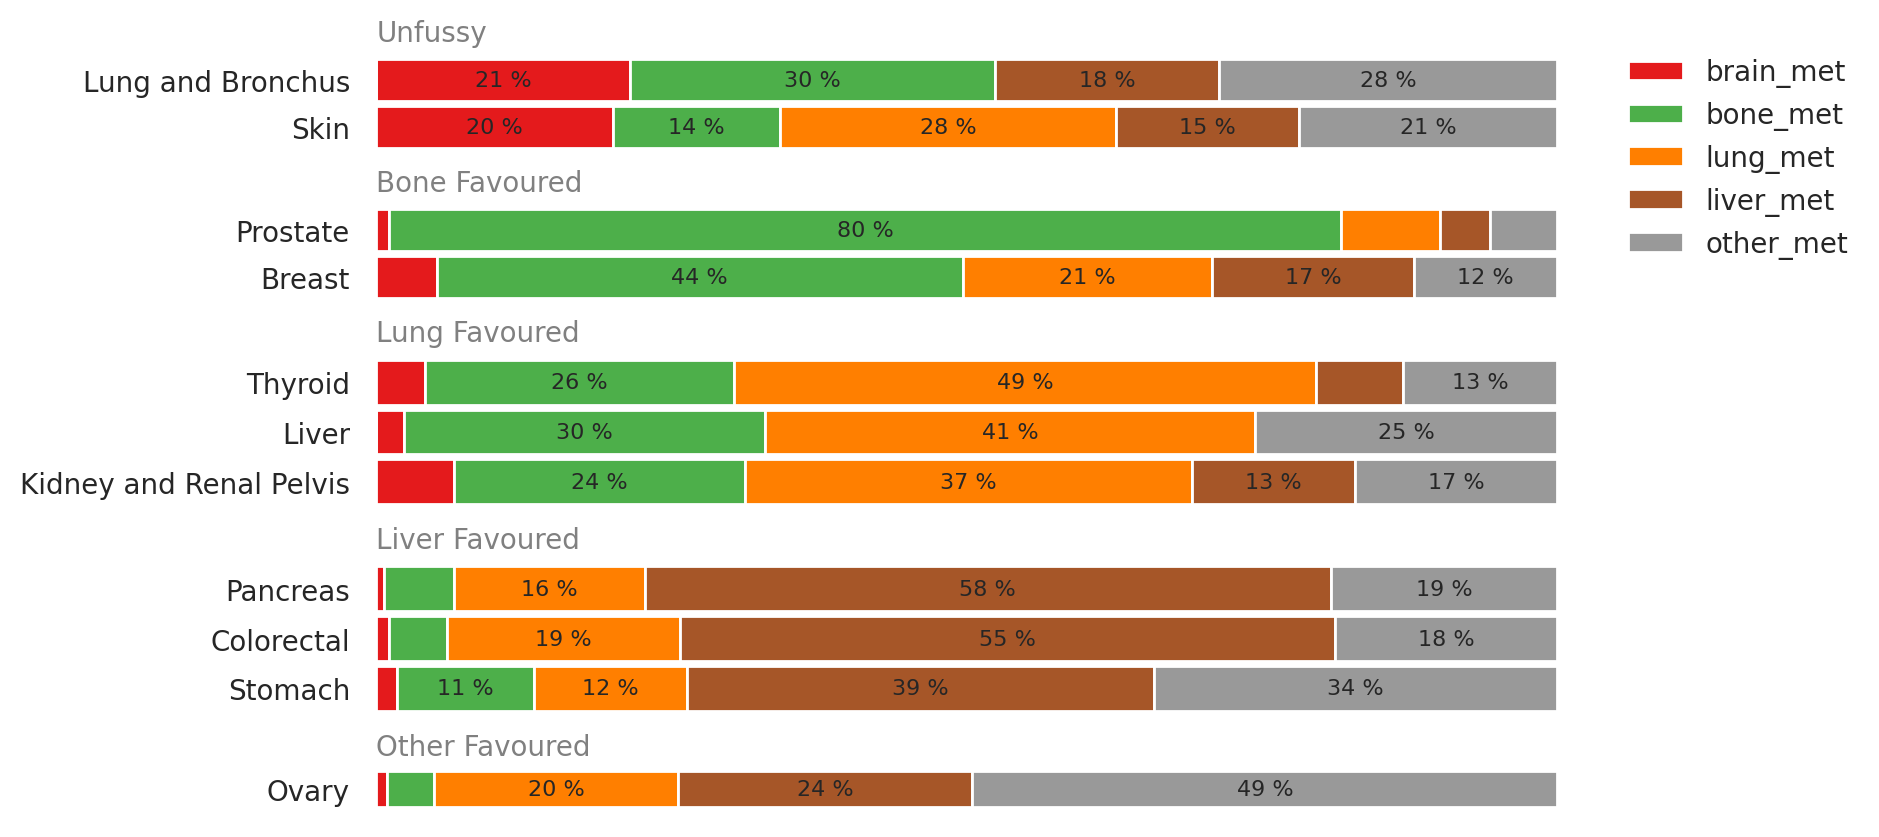

In [ ]:
sns.set_theme(style='whitegrid')
sns.set_color_codes("pastel")

# group features into favoured sites
if FEATURE == 'cancer_group':
    brain_favoured = ['Lung and Bronchus', 'Skin']
else:
    brain_favoured = [x for x in VALID_FEATURES if nframe.loc[x, 'brain_met']>=0.1]

order = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'other_met']
temp = nframe.drop(brain_favoured)
gmapper = defaultdict(set)
for feat in brain_favoured:
    gmapper['brain_met'].add(feat)
for feat, site in temp.idxmax(axis=1).items():
    gmapper[site].add(feat)
groups = [x for x in order if len(gmapper[x])>=1]

# plot
HEIGHT = 5
fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(8, HEIGHT), dpi=200, height_ratios=[len(gmapper[x]) for x in groups])
for i, group in enumerate(groups):
    ax = axes[i]
    features = list(gmapper[group])
    dfslice = nframe.loc[features]
    dfslice = dfslice.sort_values(group)
    dfslice.plot.barh(stacked=True, cmap='Set1', width=0.9, ax=ax, legend=False)
    for ix, row in dfslice.reset_index(drop=True).iterrows():
        # print(ix, row)
        cumulative = 0
        for element in row:
            if element == element and element > 0.1:
                ax.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="center",
                    fontsize=8,
                )
            cumulative += element
    # ax.set_xlim(-0.015, 1.015)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([], [])
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize=10)
    ax.grid(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    title = 'Unfussy' if group=='brain_met' else group.replace('_met', '').capitalize() + ' Favoured'
    ax.set_title(title, loc='left', pad=0, color='grey', fontsize=10)

axes[0].legend(
    bbox_to_anchor=(1, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False,
    ncol=1,
    fontsize=10
)

plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()